In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [51]:
def modelHousingMarket(p):
    
    p = parameters

    years_elapsed = [datetime.datetime.now().year]
    apartment_cost = [p["initialApartmentCost"]]
    apartments_owned = [p["initialApartmentsOwned"]]
    cost_of_living = [p["initialCostOfLiving"]]
    earnings = [p["initialEarnings"]]
    money = [p["initialMoney"]]
    apartment_earnings = [p["initialApartmentEarnings"]]

    for i in range(p["years"] - 1):
        years_elapsed.append(years_elapsed[-1] + 1)

        current_apartment_inflation = p["apartmentInflation"](i) if callable(p["apartmentInflation"]) else p["apartmentInflation"]
        current_apartment_cost = apartment_cost[-1] * (1 + current_apartment_inflation)

        apartment_cost.append(current_apartment_cost)

        current_cost_of_living_inflation = p["costOfLivingInflaiton"](i) if callable(p["costOfLivingInflaiton"]) else p["costOfLivingInflaiton"]
        current_cost_of_living = cost_of_living[-1] * (1 + current_cost_of_living_inflation)

        cost_of_living.append(current_cost_of_living)

        current_earnings_rise = p["earningsRise"](i) if callable(p["earningsRise"]) else p["earningsRise"]
        current_earnings = earnings[-1] * (1 + current_earnings_rise)
        if i > p["yearsOfWork"]:
            current_earnings = 0
        

        earnings.append(current_earnings)

        current_apartment_earnings_rise = p["apartmentsEarningRaise"](i) if callable(p["apartmentsEarningRaise"]) else p["apartmentsEarningRaise"]
        current_apartment_earnings = apartment_earnings[-1] * (1 + current_apartment_earnings_rise)

        apartment_earnings.append(current_apartment_earnings)

        current_money = money[-1] + current_earnings - current_cost_of_living + apartments_owned[-1] * current_apartment_earnings

        if current_money > current_apartment_cost:
            apartments_to_buy = np.floor(current_money / current_apartment_cost)
            
            # this error happends during edge cases with 1e100 values
            if apartments_to_buy * current_apartment_cost > current_money:
                while apartments_to_buy * current_apartment_cost > current_money:
                    rest = apartments_to_buy * current_apartment_cost - current_money
                    to_reduce = np.ceil(rest / current_apartment_cost)
                    apartments_to_buy = apartments_to_buy - to_reduce
            
            current_money -= apartments_to_buy * current_apartment_cost
            


            apartments_owned.append(apartments_owned[-1] + apartments_to_buy)
        else:
            apartments_owned.append(apartments_owned[-1])

        money.append(current_money)


    df = pd.DataFrame({
        "Years": years_elapsed,
        "Apartment cost ($)" : apartment_cost,
        "Apartments owned": apartments_owned,
        "Cost of living ($ / Year)": cost_of_living,
        "Earnings ($ / Year)": earnings,
        "Accumulated Money ($)": money,
        "Earnings from one Apartment ($ / Year)": apartment_earnings
    })
    
    df = df.set_index("Years")
    
    return df

def plot(df):
    fig, axs = plt.subplots(2,3, figsize=(20, 10))

    x = df.index
    for i, c in enumerate(df.columns):

        row = i // 3
        column = i % 3

        axs[row, column].plot(x, df[c])
        axs[row, column].set_xlabel("Year")
        axs[row, column].set_title(c)
        
        if i == 4:
            axs[row, column].axhline(0, label='No debt line', color='red', linestyle='dashed')
            axs[row, column].legend()

    plt.show()

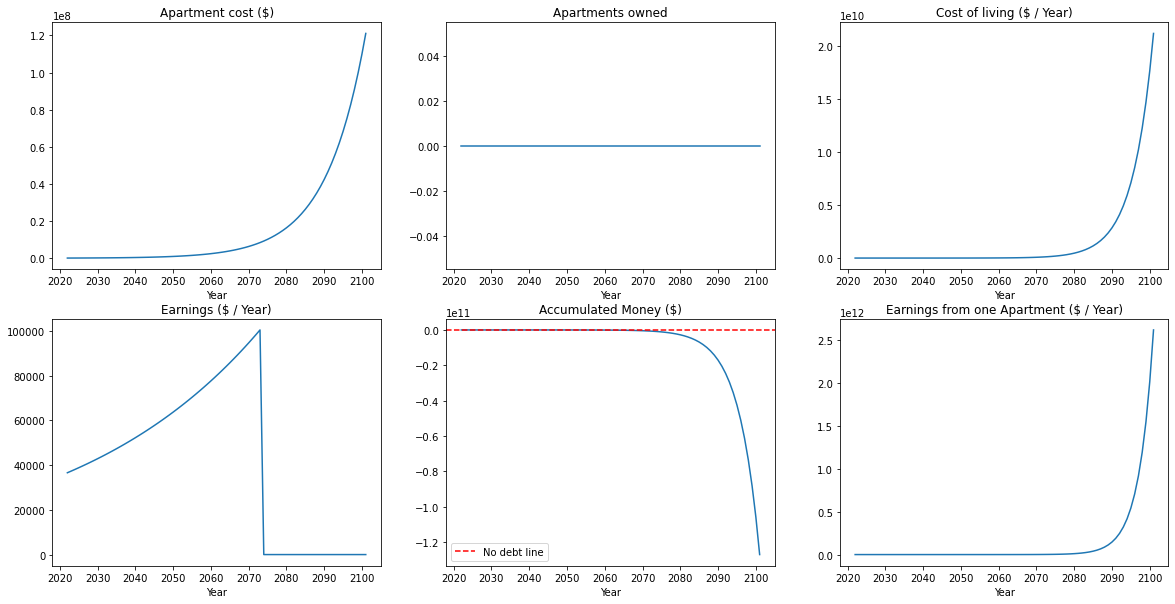

In [63]:
parameters = {
    "years": 80,
    "initialMoney": 0,
    "initialApartmentCost": 65000,
    "apartmentInflation": 0.1,
    "initialApartmentsOwned": 0,
    "initialCostOfLiving": 7836 * 1.5,
    "costOfLivingInflaiton": 0.2,
    "initialEarnings": 9144 * 4,
    "earningsRise": 0.02,
    "initialApartmentEarnings": 2604,
    "apartmentsEarningRaise": 0.30,
    "yearsOfWork": 50
}

df = modelHousingMarket(parameters)
plot(df)